# Categorical Variable - Pipeline from Metadata

In [1]:
import pandas as pd
import numpy as np
import importlib

import seaborn as sns 
import matplotlib
import matplotlib.pyplot as plt

import sys
import os

sys.path.append(os.getcwd() + "\\..\\src")
#sys.path.append('c:/Users/User/Documents/User/Work/Admiral/Pipeline_Builder/pipelineconstruction/src')

## Investigating the Input Data

Load the data we will be using as an example. This is house price data with various numeric and categorical factors. We don't particularly care about the response here as this document is on factor pre-processing. An example of the data is shown below

In [2]:
hp_train = pd.read_csv("..\\data\\raw\\HousePrices.csv")
hp_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


for this notebook we only care about the categorical columns. We will therefore drop the numeric variables to keep the dataset smaller and simpler

In [3]:
hp_cat_train = pd.concat([hp_train["Id"], hp_train.select_dtypes(include=["object"]) ], axis=1)
hp_cat_train.head()

,Id,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,1461,RH,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1,1462,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,...,Attchd,Unf,TA,TA,Y,NaN,NaN,Gar2,WD,Normal
2,1463,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Attchd,Fin,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
3,1464,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,...,Attchd,Fin,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,1465,RL,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


We will now plot the count of each of the first 9 (again to keep this small and simple) categorical variables. Starting with making the dataset long

In [4]:
hp_cat_long = pd.melt(hp_cat_train.iloc[:,0:10], id_vars=['Id'])

and then using seaborn to plot the results

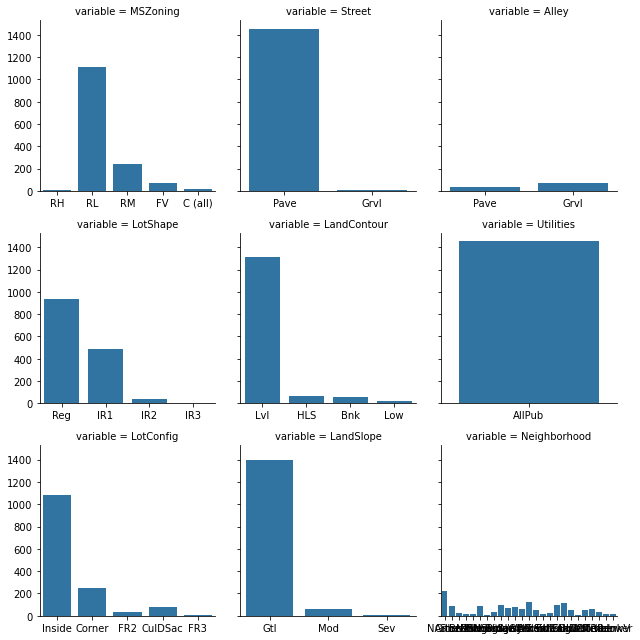

In [5]:
grid = sns.FacetGrid(hp_cat_long, col_wrap=3, col="variable", sharex=False)
grid.map_dataframe(sns.countplot, x="value")

We can see some factors such as neighbourhood have many possible values. Some columns such as street are binary. We can also see that some columns such as street have many unknowns (which aren't plotted)

We will now subset this dataset into just these variables so the example is kept smaller

In [6]:
hp_cat_train_work = hp_cat_train.iloc[:,0:10]

## Building the Metadata

We will start by showing the example metadata for this problem. Normally the metadata will be built iteratively by looking at the input to and output from the pipeline

In [7]:
control_sheet = pd.read_csv("..//controls/Housing_Categorical_ControlSheet.csv")
control_sheet

,FeatureName,TransformedName,Include,Raw,Categorical,Categorical_Level_Number,Categorical_Encoding,Categorical_Ordering,Missing_Values,Shadow_Col,Impute_Strategy,Impute_Value
0,Id,Id,N,Y,Y,100.0,NaN,NaN,-1; -2,N,NaN,NaN
1,MSZoning,MSZoning,Y,Y,Y,NaN,ordinal,C (all); I; A; FV; RP; RL; RM; RH,NaN,N,constant,Unknown
2,Street,Street,Y,Y,Y,NaN,ordinal,NaN,NaN,N,most_frequent,NaN
3,Alley,Alley,Y,Y,Y,NaN,ordinal,NaN,NaN,N,constant,Unknown
4,LotShape,LotShape,Y,Y,Y,NaN,ordinal,Reg; IR1; IR2; IR3,NaN,N,constant,Unknown
5,LandContour,LandContour,N,Y,Y,NaN,ordinal,Lvl; Bnk; HLS; Low,NaN,N,constant,Unknown
6,Utilities,Utilities,N,Y,Y,NaN,NaN,NaN,NaN,N,constant,Unknown
7,LotConfig,LotConfig,Y,Y,Y,3.0,one_hot,NaN,NaN,N,constant,Unknown
8,LandSlope,LandSlope,Y,Y,Y,NaN,ordinal,Gtl; Mod; Sev,NaN,N,constant,Unknown
9,Neighborhood,Neighborhood,Y,Y,Y,5.0,frequency,NaN,NAmes,N,constant,Unknown


## Building the Column Transformer Pipeline

We will then import sklearn tools and our custom transformations

These are standard sklearn tools

In [8]:
# Import standard functions
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

This is the custom code to build the pipeline

In [9]:
from construction.BuildCategoricalPipeline import BuildCategoricalPipeline
importlib.reload(sys.modules[BuildCategoricalPipeline.__module__])

<module 'construction.BuildCategoricalPipeline' from 'c:\\Users\\User\\Documents\\User\\Work\\Admiral\\Pipeline_Builder\\pipelineconstruction\\notebooks\\..\\src\\construction\\BuildCategoricalPipeline.py'>

which in case you're interested uses the following custom transformers

In [10]:
# Import custom functions
from transformers.IdentifyUnknowns import IdentifyUnknowns
from transformers.FrequencyEncoder import FrequencyEncoder
from transformers.CategoricalCatLimit import CategoricalCatLimit

from transformers.names_from_ColumnTransformer import names_from_ColumnTransformer

importlib.reload(sys.modules[IdentifyUnknowns.__module__])
importlib.reload(sys.modules[FrequencyEncoder.__module__])
importlib.reload(sys.modules[CategoricalCatLimit.__module__])

<module 'transformers.CategoricalCatLimit' from 'c:\\Users\\User\\Documents\\User\\Work\\Admiral\\Pipeline_Builder\\pipelineconstruction\\notebooks\\..\\src\\transformers\\CategoricalCatLimit.py'>

We can then call our pipeline former using the metadata

In [11]:
col_transformers_list = BuildCategoricalPipeline(control_sheet)

We now have a list of tuples in the form of a sklearn column transformation object. Which looks something like this

In [12]:
col_transformers_list

[('MSZoning',
  Pipeline(steps=[('impute',
                   SimpleImputer(fill_value='Unknown', strategy='constant')),
                  ('encode',
                   OrdinalEncoder(categories=[['Unknown', 'C (all)', 'I', 'A',
                                               'FV', 'RP', 'RL', 'RM', 'RH']]))]),
  ['MSZoning']),
 ('Street',
  Pipeline(steps=[('impute',
                   SimpleImputer(fill_value=nan, strategy='most_frequent')),
                  ('encode', OrdinalEncoder())]),
  ['Street']),
 ('Alley',
  Pipeline(steps=[('impute',
                   SimpleImputer(fill_value='Unknown', strategy='constant')),
                  ('encode', OrdinalEncoder())]),
  ['Alley']),
 ('LotShape',
  Pipeline(steps=[('impute',
                   SimpleImputer(fill_value='Unknown', strategy='constant')),
                  ('encode',
                   OrdinalEncoder(categories=[['Unknown', 'Reg', 'IR1', 'IR2',
                                               'IR3']]))]),
  ['LotShape']),


looking at a single column to keep this simple we find the below. Notice that the second object (indexed by 1) is a Pipeline object which contains all the transformations

In [13]:
col_transformers_list[6]

('Neighborhood',
 Pipeline(steps=[('unk_levels', IdentifyUnknowns(unk_levels=[['NAmes']])),
                 ('impute',
                  SimpleImputer(fill_value='Unknown', strategy='constant')),
                 ('cat_capping', CategoricalCatLimit(cat_num=[5])),
                 ('encode',
                  FrequencyEncoder(keep_at_end='other',
                                   keep_at_start='Unknown'))]),
 ['Neighborhood'])

Each of these object can be applied on its own (see below) rather than the whole column transformer

In [14]:
col_transformers_list[6][1].fit_transform(hp_cat_train_work[["Neighborhood"]])

array([[0.],
       [0.],
       [5.],
       ...,
       [5.],
       [5.],
       [5.]])

We can now build the column transformer object and train it on the data (normally this would be the test set). 

In [15]:
col_tran = ColumnTransformer(col_transformers_list)
X_t = col_tran.fit_transform(hp_cat_train_work)

turning the transformed matrix into a pandas dataframe and showing to top few results gives the below output where we can see that all columns are now numeric (as needed)

In [16]:
X_t_df = pd.DataFrame(X_t, columns=names_from_ColumnTransformer(col_tran))
X_t_df.head()

,MSZoning,Street,Alley,LotShape,LotConfig_Corner,LotConfig_CulDSac,LotConfig_Inside,LotConfig_other,LandSlope,Neighborhood
0,8.0,1.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,6.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0
2,6.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,5.0
3,6.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,5.0
4,6.0,1.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,5.0


To see the distributions of each factor we can do some plotting with seaborn to show the factor distributions

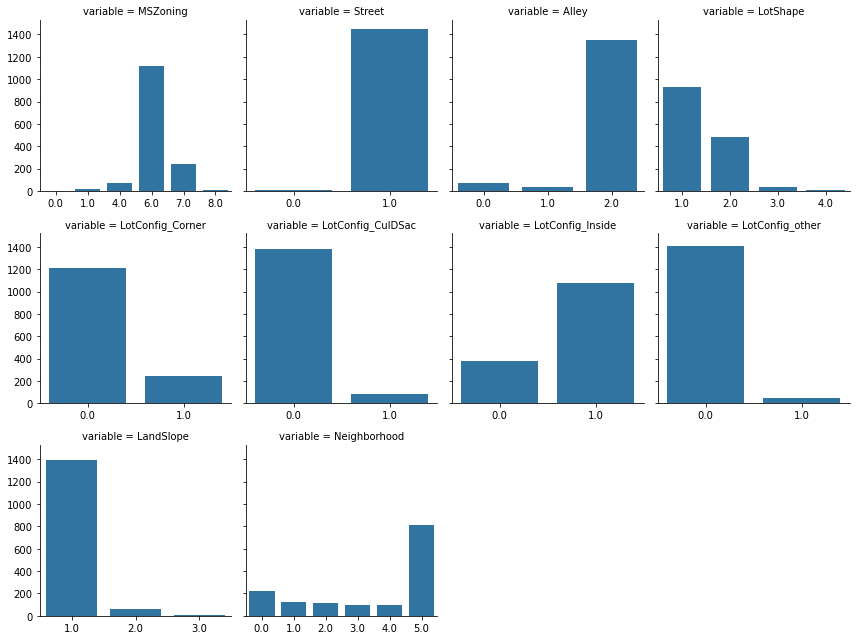

In [17]:
X_t_id = pd.concat([hp_train["Id"], X_t_df ], axis=1)
X_t_long = pd.melt(X_t_id, id_vars=['Id'])
grid = sns.FacetGrid(X_t_long, col_wrap=4, col="variable", sharex=False)
grid.map_dataframe(sns.countplot, x="value")

If we want to know what 2.0 means in neighbourhood we can inspect the column transformer object as this contains all the fitted pipelines (see below). Unfortunately, we have lost the inverse_transform methods due to this being a column transformer.

In [18]:
col_tran.transformers_[6][1]["encode"].categories_

[array(['Unknown', 'OldTown', 'CollgCr', 'Somerst', 'Edwards', 'other'],
       dtype=object)]